## LinearSoftmax model (LS) - Ver1(no optimizations)

* Same as LinearSoftmax model (LS) - Ver0, but no more optimizations such as PCA, t-SNE and similar result without confusion matrix.

### Python Lib Version List (tested and recommended, other latest version may works as well)
* Python 3.6.8
* Numpy 1.16.2
* Keras 2.2.4
* Scikit-image 0.14.2

In [1]:
import os
from skimage import io
import numpy as np

from scipy.misc import imresize
from skimage.color import gray2rgb

import keras.backend as K
from keras.models import Model
from keras.applications import vgg16

from keras.layers import Input, Dense
from keras import optimizers
from keras.models import model_from_json

from random import shuffle
import time

Using TensorFlow backend.


* target folder - data directory of the project, placed under the same root directory of this notebook, named as 'data_folder'
* class_folder - categorical folder under data directory, placed under target_folder, named by each individual CNT class

In [2]:
def load_NIOSH(filenames_path):
    #load images from paths specified in filenames to a np array
    #return the np array, and an array of labels as a np array
    #preprocess the images for vgg use as well
    label_dict = dict()
    label_dict['CNT-Cluster'] = [1, 0, 0, 0]
    label_dict['CNT-fiber'] = [0, 1, 0, 0]
    label_dict['CNT-Matrix'] = [0, 0, 1, 0]
    label_dict['CNT-MatrixSurface'] = [0, 0, 0, 1]

    target_folder = 'data_folder'

    filenames = open(filenames_path, 'r')
    filenames_list = filenames.readlines()
    filenames.close()

    images = []
    image_labels = []
    for filename in filenames_list:
        filename = filename.strip()
        label_key = os.path.split(filename)[0] 
        image = io.imread(os.path.join(target_folder, filename))

        #preprocess the image for vgg16
        image = imresize(image, (224, 224))
        image = gray2rgb(image)
        label = label_dict[label_key]
        images.append(image)
        image_labels.append(label)
    return vgg16.preprocess_input(np.array(images)), np.array(image_labels)

In [3]:
#extract vgg features
def vgg_model(output_layer='fc2'):
    cnn = vgg16.VGG16(include_top=True, weights='imagenet')
    model = Model(inputs=cnn.input, outputs=cnn.get_layer(output_layer).output)
    return model

In [4]:
#linear softmax layer that uses the vgg features to classify the images
def linear_softmax_classifier(n_classes=4, input_dim=4096): # num of classes
    input_layer = Input(shape=(input_dim,))
    output_layer = Dense(n_classes, input_shape=(input_dim,), activation='softmax')(input_layer)
    return Model(inputs=input_layer, outputs=output_layer)

### Training modulus
* PC configuration: 
    - CPU - i7-8700K
    - GPU - RTX2070
    - RAM - 32GB
* Takes about 6mins on 3200 images with 40 epochs
* Output:
    - 'LS_model.json' JS file output of the CNN model
    - 'LS_weights.h5'data file output of the weights creating by this training modulus

In [5]:
print('Please set number of epoch to learn:')
num_epoch = int(input())

Please set number of epoch to learn:
40


In [6]:
target_folder = 'data_folder'
class_folders = ['CNT-Cluster', 'CNT-fiber', 'CNT-Matrix', 'CNT-MatrixSurface']
num_images = [800, 800, 800, 800]

train_list = open('train.txt', 'w')
for i, class_folder in enumerate(class_folders):
    filenames = os.listdir(os.path.join(target_folder, class_folder))
    #get a random shuffle of the filenames
    shuffle(filenames)
    for j in range(num_images[i]):
        train_list.write(os.path.join(class_folder, filenames[j]) + '\n')
train_list.close()

In [7]:
# counting time
localtime = time.asctime(time.localtime(time.time()))
start = time.time()
print('Program Started: {}'.format(localtime))
    
train_images, train_labels = load_NIOSH('train.txt')
features = vgg_model()
train_features = features.predict(train_images, verbose=True, batch_size=1)

#create a softmax classifier for the feature data, and train / eval on the test data
LS = linear_softmax_classifier()
opt = optimizers.Adam(lr=0.001)
LS.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
LS.fit(train_features, train_labels, epochs=num_epoch, batch_size=1, verbose=2)

# save model and weights
LS_model = LS.to_json()
with open('LS_model.json', 'w') as JSfile:
    JSfile.write(LS_model)
print('Successfully save linearsoftmax model.')
LS.save_weights('LS_weights.h5')
print('Successfully save linearsoftmax trainned weights.')

print('Program ended: {}'.format(localtime))
end = time.time()
print('This progress takes {} minutes to run!'.format((end-start)/60))

Program Started: Thu May 28 23:40:26 2020


E:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


3200/3200 [==============================] - 28s 9ms/step
Epoch 1/40
 - 4s - loss: 1.4600 - acc: 0.7441
Epoch 2/40
 - 4s - loss: 1.2484 - acc: 0.8194
Epoch 3/40
 - 4s - loss: 1.0943 - acc: 0.8559
Epoch 4/40
 - 4s - loss: 0.9936 - acc: 0.8709
Epoch 5/40
 - 4s - loss: 0.7273 - acc: 0.8919
Epoch 6/40
 - 4s - loss: 0.5921 - acc: 0.9081
Epoch 7/40
 - 4s - loss: 0.6069 - acc: 0.9091
Epoch 8/40
 - 4s - loss: 0.5423 - acc: 0.9241
Epoch 9/40
 - 4s - loss: 0.4663 - acc: 0.9391
Epoch 10/40
 - 4s - loss: 0.4765 - acc: 0.9387
Epoch 11/40
 - 4s - loss: 0.3681 - acc: 0.9456
Epoch 12/40
 - 4s - loss: 0.3633 - acc: 0.9481
Epoch 13/40
 - 4s - loss: 0.3202 - acc: 0.9531
Epoch 14/40
 - 4s - loss: 0.2978 - acc: 0.9556
Epoch 15/40
 - 4s - loss: 0.3586 - acc: 0.9494
Epoch 16/40
 - 4s - loss: 0.2420 - acc: 0.9619
Epoch 17/40
 - 4s - loss: 0.2584 - acc: 0.9634
Epoch 18/40
 - 4s - loss: 0.2316 - acc: 0.9625
Epoch 19/40
 - 4s - loss: 0.1733 - acc: 0.9709
Epoch 20/40
 - 4s - loss: 0.2065 - acc: 0.9703
Epoch 21/40

### Testing modulus
* Takes just few ms per image
* Input:images in the test folder and files created from training modulus
    - test_folder: test data directory for images, placed under the data_folder, named as 'TEST' for our case.
    - Previous model: 'LS_model.json'
    - Previous trained weights: 'LS_weights.h5'
    
* Output:the tested image, label, time cost and accuracy 
* t-SNE and confusion matrix used in LinearSoftmax model (LS) - Ver0, similified here in Ver1

In [8]:
def load_test(filenames_path):
    from PIL import Image, ImageOps
    #load images from paths specified in filenames to a np array
    #return the np array, and an array of labels as a np array
    #preprocess the images for vgg use as well
    target_folder = 'data_folder'
    filenames = open(filenames_path, 'r')
    filenames_list = filenames.readlines()
    filenames.close()

    images = []
    for i, filename in enumerate(filenames_list):
        filename = filename.strip()
        image = io.imread(os.path.join(target_folder, filename))
        #preprocess the image for vgg16
        image = imresize(image, (224, 224))
        image = gray2rgb(image)
        images.append(image)
        im = Image.open(os.path.join(target_folder, filename))
        im = ImageOps.fit(im, (224, 224), Image.ANTIALIAS)
        display(im)
        print("Figure {}: {}".format(i+1, filename.replace('TEST\\', '')))
    return vgg16.preprocess_input(np.array(images))

In [9]:
def run_test():
    # find selected test image in path
    target_folder = 'data_folder'
    test_list = open('test.txt', 'w')
    test_folder = 'TEST'
    test_filenames = os.listdir(os.path.join(target_folder, test_folder))
    for i in range(len(test_filenames)):
        test_list.write(os.path.join(test_folder, test_filenames[i]) + '\n')
    test_list.close()

    # load test image and pre-trainned weights
    test_images = load_test('test.txt')
    features = vgg_model()
    test_features = features.predict(test_images, verbose=True, batch_size=1)

    # load model plus weights
    JSfile = open('LS_model.json', 'r')
    LS_model = JSfile.read()
    JSfile.close()
    LS = model_from_json(LS_model)
    LS.load_weights('LS_weights.h5')

    # predict
    pred = LS.predict(test_features, verbose=1, batch_size=1)
    return pred, test_filenames

In [10]:
def main():
    # counting time
    localtime = time.asctime(time.localtime(time.time()))
    start = time.time()
    print('Program Started: {}'.format(localtime))

    pred, test_list = run_test()
    
    # counting time
    print('Program ended: {}'.format(localtime))
    end = time.time()
    num=len(np.argmax(pred, axis=1))
    print('This progress takes {} seconds to run, totally {} images are processed, average {:.2f} second(s) per image!'.format(end-start, num, (end-start)/num))
    
    label_dict = {0:'CNT-Cluster', 1:'CNT-Fiber', 2:'CNT-Matrix', 3:'CNT-MatrixSurface'}
    label = np.argmax(pred, axis=1)
    num = len(label)
    Cl_prob = np.count_nonzero(label == 0)/num
    Fi_prob = np.count_nonzero(label == 1)/num
    Ma_prob = np.count_nonzero(label == 2)/num
    MS_prob = np.count_nonzero(label == 3)/num
    print('\nThere are {} images been processed, classified as {:.2%} CNT-Cluster, {:.2%} CNT-Fiber, {:.2%} CNT-Matrix and {:.2%} CNT-MatrixSurface.'
    .format(num, Cl_prob, Fi_prob, Ma_prob, MS_prob))
    for i, test_name in enumerate(test_list):
        print('The predicted label for No.{} - {} is {}.'.format(i+1, test_name, label_dict[label[i]]))



Program Started: Thu May 28 23:46:34 2020


E:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


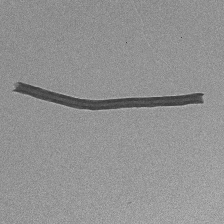

Figure 1: FIBER.tif


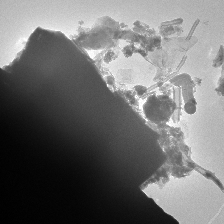

Figure 2: MATRIX-SURFACE.tif


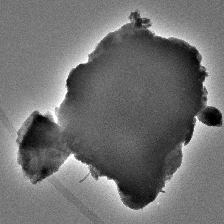

Figure 3: MATRIX.tif
3/3 [==============================] - 0s 7ms/step
Program ended: Thu May 28 23:46:34 2020
This progress takes 1.8370561599731445 seconds to run, totally 3 images are processed, average 0.61 second(s) per image!

There are 3 images been processed, classified as 0.00% CNT-Cluster, 33.33% CNT-Fiber, 33.33% CNT-Matrix and 33.33% CNT-MatrixSurface.
The predicted label for No.1 - FIBER.tif is CNT-Fiber.
The predicted label for No.2 - MATRIX-SURFACE.tif is CNT-MatrixSurface.
The predicted label for No.3 - MATRIX.tif is CNT-Matrix.


In [11]:
if __name__ == '__main__':
    main()